# STAT 542 - Statistical Learning

# Homework 5 - Manan Mehta (mananm2)

## Due: 09/28/2020

## About HW5

We utilize the coordinate descent algorithm introduced in the class with the one variable Lasso algorithm from the last homework to complete the entire Lasso solution. This involves two steps: in the first step, we solve the solution for a fixed $\lambda$ value, while in the second step, we consider a grid of $\lambda$ value and solve it using the path-wise coordinate descent.

In [1]:
#Import all the necessary packages
import numpy as np

from scipy.stats import norm
from scipy.stats import multivariate_normal as mvrnorm
from scipy.stats import uniform

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import lasso_path

## Question 1 (40 Points) Lasso Solution for Fixed $\lambda$

For this question, you cannot use functions from any additional library in your algorithm. Following HW4, we use the this version of the objective function:

$$\arg\min_{\beta} \frac{1}{2n} \lVert \mathbf{y} - \mathbf{X}\beta \rVert^2 + \lambda \lVert \beta \rVert_1$$

The following data is used to fit this model. Note that the `MASS` package can only be used to generate multivariate normal data. You can consider using similar functions in Python if needed.

In [2]:
n , p = 100 , 200

#Generate Data

#Covariance matrix with Vii = 1, Vij = 0.3
V = 0.3*np.ones([p,p])
np.fill_diagonal(V , 1)
#Mean vector = 0
mu = np.zeros(p)
#Sample 100 covariates from multivariate normal dist
X_org = mvrnorm.rvs(mean = mu, cov = V, size = n, random_state = 10)
#True parameters beta
true_beta = np.append(uniform.rvs(loc=-1, scale=2, size=10, random_state = 10) , np.zeros(p-10))
#i.i.d. Noise
epsilon = norm.rvs(size = n, random_state = 10)
# y = X*beta + noise
y_org = X_org.dot(true_beta) + epsilon

# Pre-scale and Center X and y
ss = StandardScaler()
X = ss.fit_transform(X_org)
y = ss.fit_transform(y_org.reshape(-1,1)).reshape(n,)

lamda = 0.3

We will use the pre-scale and centered data `X` and `y` for this question, hence no intercept is needed. Write a Lasso algorithm function `myLasso(X, y, lambda, tol, maxitr)` which will output a vector of $\beta$ values **without** the intercept. You need to consider the following while completing this question:

  * Do not use functions from any additional library
  * Start with a vector $\boldsymbol \beta = \mathbf{0}$
  * Use the soft-threshold function you developed in HW4. 
  * Use the efficient $\mathbf{r}$ update algorithm we introduced during the lecture.
  * Run your coordinate descent algorithm for a maximum of `maxitr` = 100 iterations (while each iteration will loop through all variables). However, stop your algorithm if the $\boldsymbol \beta$ value of the current iteration is sufficiently similar to the previous one, i.e., $\lVert \boldsymbol \beta^{(k)} - \boldsymbol \beta^{(k-1)} \rVert^2 \leq \text{tol}$. Set `tol = 1e-7`.
  * After running the algorithm, print out the first 10 variables.
  * Finally, check and compare your answer to the `sklearn` package.

In [3]:
#The soft thresholding function developed in HW4
def soft_th(b , lamda = 1):
    '''
    Function to calculate the parameter for Lasso Regression
    given the OLS parameter
    (1 variable Lasso)
    
    Inputs:
    b     : OLS estimator
    lamda : penalty level
    
    Outputs:
    b_lasso : Estimator for lasso regression
    
    '''
    if b > lamda:
        return b - lamda
    elif b < (-lamda):
        return b + lamda
    elif abs(b) <= lamda:
        return 0
    else:
        print("Error!")
        return 1e5

    
#Lasso implementation function
def myLasso(X, y, lamda, tol = 1e-07, maxitr = 100):
    '''
    Function to implement co-ordinate descent algorithm
    to find the solution to Lasso Regression
    (multi variable Lasso)
    
    Works with the soft_th function written above
    
    Inputs:
    X      : Covariate matrix (n x p)
    y      : Output values (n x 1)
    lamda  : penalty level
    tol    : tolerance for parameter updates (optional)
    maxitr : Maximum outer iterations in coordinate descent (optional)
    
    Outputs:
    beta   : Estimated Parameters for Lasso Regression (p x 1)
    
    '''    
    p = X.shape[1]
    
    #Set a common denominator = (xj^T xj) as the data is scaled
    den = X[:,1].T.dot(X[:,1])
    
    #Start with all betas zero
    beta = np.zeros(p)
    
    for count in range(maxitr):
        #Store the previous beta
        beta_prev = list(beta)
        
        
        # r for beta_0
        r = y - X[:,1:].dot(beta[1:])
        beta_ols = X[:,0].T.dot(r) / den
        beta[0] = soft_th(beta_ols , lamda)

        # update from 1 to p
        for j in range(1,p):
            #efficient r update
            r = r - beta[j-1]*X[:,j-1] + beta[j]*X[:,j]
            beta_ols = X[:,j].T.dot(r) / den
            beta[j] = soft_th(beta_ols , lamda)
        
        #Check if the change in beta is less than acceptable tolerance
        if np.linalg.norm(beta - beta_prev) <= tol:
            print("Tolerance reached after {} iterations\n".format(count))
            break
    
    return beta   

In [4]:
#Using the function myLasso
beta_lasso = myLasso(X, y, lamda)
print("The first 10 variables from the function myLasso are:")
print(np.round(beta_lasso[:10] , 3))

#Using the Lasso model from scikit-learn library
reg = Lasso(alpha = lamda, fit_intercept = False).fit(X,y)
print("\nThe first 10 variables from Python's Lasso Regression are:")
print(np.round(reg.coef_[:10] , 3))

Tolerance reached after 13 iterations

The first 10 variables from the function myLasso are:
[ 0.    -0.257  0.     0.     0.     0.    -0.044  0.    -0.009 -0.153]

The first 10 variables from Python's Lasso Regression are:
[ 0.    -0.257  0.     0.    -0.    -0.    -0.044  0.    -0.009 -0.153]


We see that our function is correct, as the parameter estimates are identical.

## Question 2 (40 Points) Path-wise Coordinate Descent

Let's modify our Lasso code to perform path-wise coordinate descent. The idea is simple: we will solve the solution on a grid of $\lambda$ values, starting from the largest one. After obtaining the optimal $\boldsymbol \beta$ for a given $\lambda$, we simply use this solution as the initial value (instead of all zero) for the next (smaller) $\lambda$. This is referred to as a warm start in optimization problems. For more details, please watch the lecture video. We will consider the following grid of $\lambda$, with the `sklearn.linear_model.lasso_path` solution of the first 10 variables plotted. 

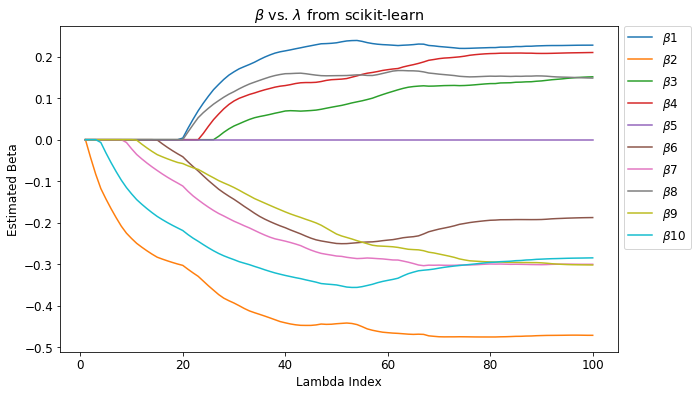

In [5]:
lamda_all, betamat, _ = lasso_path(X, y)

plt.figure(figsize = (10,6))
for i in range(10):
    plt.plot(range(1,101) , betamat[i] , label = r'$\beta$'+str(i+1))
plt.xlabel("Lambda Index")
plt.ylabel("Estimated Beta")
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.title(r'$\beta$ vs. $\lambda$ from scikit-learn')
plt.show()

You need to add an additional input argument `lambda_all` to your Lasso function. After finishing your algorithm, output a matrix that records all the fitted parameters on your $\lambda$ grid. 

  * Provide a plot same as the above `sklearn.linear_model.lasso_path` solution plot of the first 10 variables. 
  * Which two variables enter the model (start to have nonzero values) first?
  * What is the maximum discrepancy between your solution and `sklearn.linear_model.lasso_path`? 

In [6]:
#We modify the "myLasso" function to "myLasso_pathwise"
def myLasso_pathwise(X, y, lamda_all, tol = 1e-07, maxitr = 100):
    '''
    Function to implement co-ordinate descent algorithm
    to find the solution to Lasso Regression
    with pathwise updates for lamda
    (multi variable Lasso)
    
    Works with the soft_th function written above
    
    Inputs:
    X         : Covariate matrix (n x p)
    y         : Output values (n x 1)
    lamda_all : (sorted) penalty level array (b x 1)
    tol       : tolerance for parameter updates (optional)
    maxitr    : Maximum outer iterations in coordinate descent (optional)
    
    Outputs:
    betamat   : Estimated Parameters for Lasso Regression at each lamda (b x p)
    
    '''    
    p = X.shape[1]
    b = len(lamda_all)
    
    betamat = np.zeros([b,p])
    
    #Set a common denominator = (xj^T xj) as the data is scaled
    den = X[:,1].T.dot(X[:,1])
    
    #Start loop for lamda
    for i in range(b):
        if i == 0:
            betamat[i] = np.zeros(p)
            continue    
        else:
            #Start with betas from the previous lambda
            beta = list(betamat[i-1])
        
        for count in range(maxitr):
            #Store the previous beta
            beta_prev = list(beta)
            
            # r for beta_0
            r = y - X[:,1:].dot(beta[1:])
            beta_ols = X[:,0].T.dot(r) / den
            beta[0] = soft_th(beta_ols , lamda_all[i])

            # update from 1 to p
            for j in range(1,p):
                #efficient r update
                r = r - beta[j-1]*X[:,j-1] + beta[j]*X[:,j]
                beta_ols = X[:,j].T.dot(r) / den
                beta[j] = soft_th(beta_ols , lamda_all[i])
            

            #Check if the change in beta is less than acceptable tolerance
            if np.linalg.norm(np.array(beta) - beta_prev) <= tol:
                break
        
        betamat[i] = beta
        
    return betamat.T

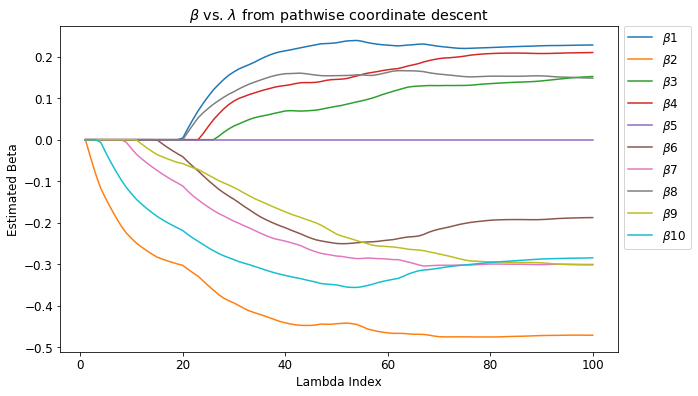

In [7]:
betamat_myLasso = myLasso_pathwise(X, y, lamda_all)

#Plot the results
plt.figure(figsize = (10,6))
for i in range(10):
    plt.plot(range(1,101) , betamat_myLasso[i] , label = r'$\beta$'+str(i+1))
plt.xlabel("Lambda Index")
plt.ylabel("Estimated Beta")
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.title(r'$\beta$ vs. $\lambda$ from pathwise coordinate descent')
plt.show()

We see that $\beta_2$ enters the model first, followed by $\beta_{10}$.

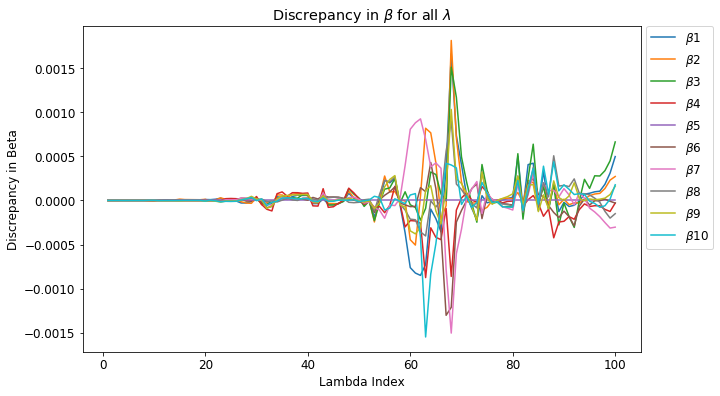

In [8]:
plt.figure(figsize = (10,6))
for i in range(10):
    plt.plot(range(1,101) , betamat_myLasso[i] - betamat[i] , label = r'$\beta$'+str(i+1))
plt.xlabel("Lambda Index")
plt.ylabel("Discrepancy in Beta")
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.title(r'Discrepancy in $\beta$ for all $\lambda$')
plt.show()

The maximum discrepancy in our solution vs. the `lasso_path` from Python is **~ 0.0015** as seen from the figure.

## Question 3 (20 Points) Recovering the Original Scale

The formula provided in HW4 can also be used when there are multiple variables. 

$$
\begin{align}
\frac{Y - \bar{Y}}{\text{sd}_y} =&~ \sum_{j=1}^p \frac{X_j - \bar{X}_j}{\text{sd}_j} \gamma_j \\
Y =&~ \underbrace{\bar{Y} - \sum_{j=1}^p \bar{X}_j \frac{\text{sd}_y \cdot \gamma_j}{\text{sd}_j}}_{\beta_0} + \sum_{j=1}^p X_j \underbrace{\frac{\text{sd}_y \cdot \gamma_j}{\text{sd}_j}}_{\beta_j},
\end{align}
$$

Use this formula to recover the original scale of the $\boldsymbol \beta$, including the intercept term $\beta_0$. 

  * Use the following code of `sklearn.linear_model.lasso_path` to obtain a solution path. 

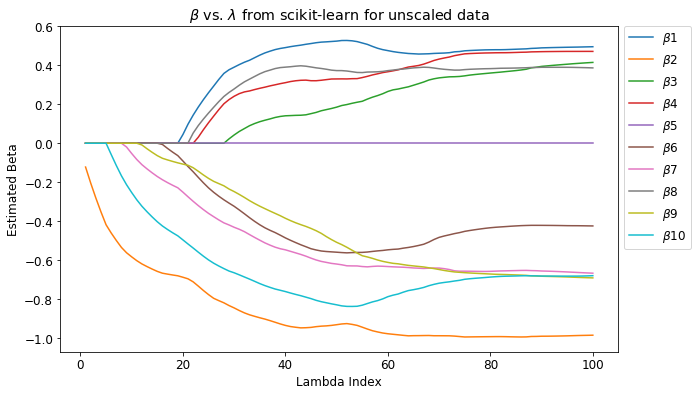

In [9]:
#Note that we now directly input the unscaled data into the lasso_path function
#Also note that the lasso_path has no option for fitting an intercept or standardizing
#Hence results may differ from glmnet in R
_, betamat_q3, _ = lasso_path(X_org, y_org, alphas = lamda_all*y_org.std())

plt.figure(figsize = (10,6))
for i in range(10):
    plt.plot(range(1,101) , betamat_q3[i] , label = r'$\beta$'+str(i+1))
plt.xlabel("Lambda Index")
plt.ylabel("Estimated Beta")
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.title(r'$\beta$ vs. $\lambda$ from scikit-learn for unscaled data')
plt.show()

* After recovering your $\boldsymbol \beta$ values, produce a plot of your solution path. 
* What is the maximum discrepancy between your solution and `lasso_path`?

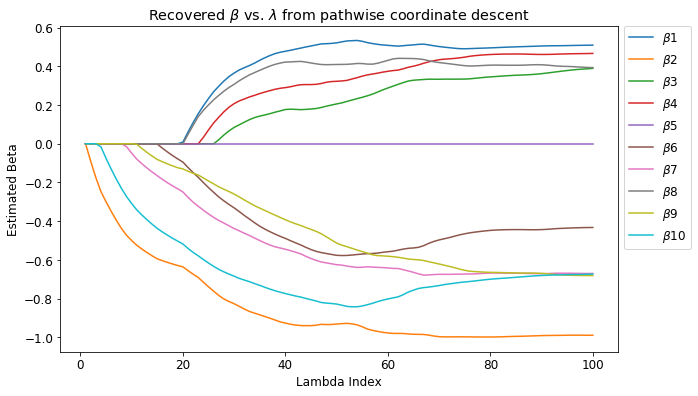

In [10]:
def recover_betas(X_org, y_org, betamat):
    betamat_recovered = np.zeros((201,100))
    
    Xmean, Xstd, ymean, ystd = X_org.mean(axis = 0), X_org.std(axis = 0), y_org.mean(axis = 0), y_org.std(axis = 0)
    
    beta_rescaled = ystd * betamat / Xstd.reshape(-1,1) 
    
    betamat_recovered[0] = ymean - (beta_rescaled * Xmean.reshape(-1,1)).sum(axis = 0)
    
    betamat_recovered[1:] = beta_rescaled
    
    return betamat_recovered


betamat_recovered = recover_betas(X_org, y_org, betamat_myLasso)

plt.figure(figsize = (10,6))
for i in range(10):
    plt.plot(range(1,101) , betamat_recovered[i+1] , label = r'$\beta$'+str(i+1))
plt.xlabel("Lambda Index")
plt.ylabel("Estimated Beta")
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.title(r'Recovered $\beta$ vs. $\lambda$ from pathwise coordinate descent')
plt.show()

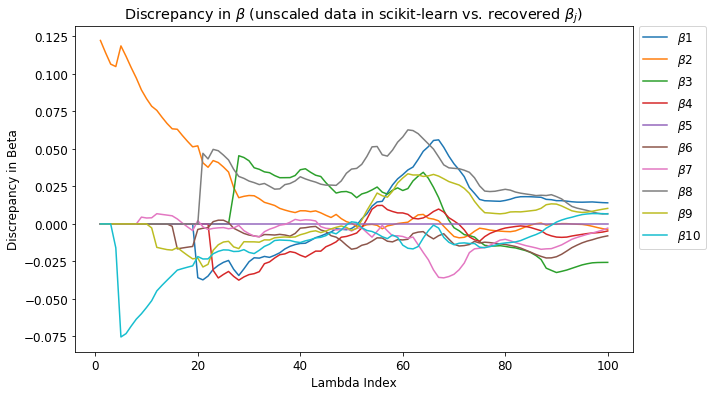

In [11]:
plt.figure(figsize = (10,6))
for i in range(10):
    plt.plot(range(1,101) , betamat_recovered[i+1] - betamat_q3[i] , label = r'$\beta$'+str(i+1))
plt.xlabel("Lambda Index")
plt.ylabel("Discrepancy in Beta")
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.title(r'Discrepancy in $\beta$ (unscaled data in scikit-learn vs. recovered $\beta_j$)')
plt.show()

The maximum discrepancy in our solution vs. the `lasso_path` from Python is **~ 0.125** as seen from the figure.

**[Bonus 5 Points]** If we do not specify `lambdas` in the following `lasso_path` function, the package will pick a different grid, which lead to a different set of solution. Explain how the `lambda` values are picked in this case. What is the largest `lambda` being considered? And why we don't need to consider a larger `lambda` value? Consider reading the following paper (section 2.5) and the documentation of the `lasso_path` (Python) or `glmnet()` (R) function. Please note that the descriptions from these two sources are slightly different, with similar ideas.
   * Friedman, Jerome, Trevor Hastie, and Rob Tibshirani. "Regularization paths for generalized linear models via coordinate descent." Journal of statistical software 33, no. 1 (2010): 1.

When we don't specify the $\lambda$ grid, the grid is selected by the solver based on a data dervied $\lambda_{max}$ and a `lambda.min.ratio`. The $\lambda_{max}$ is the smallest value of $\lambda$ for which the entire vector $\hat\beta = 0$. We don't need to consider any value higher than this $\lambda$ as for a higher penalty, no variable will enter the lasso solution. Thus, $\hat\beta = 0$ for all $\lambda \gt \lambda_{max}$

From the soft thresholding function, we can see that the $\tilde\beta_j$ for a covariate will stay zero if $\frac{1}{N} \lvert \langle x_j, y \rangle \rvert \lt \lambda $ . hence, we select the other end of the grid as a $\lambda_{min} = \epsilon \lambda_{max}$ and construct a sequence of $K$ values from $\lambda_{max}$ to $\lambda_{min}$ on the log scale.

In our case, we observe that $\lambda_{max} = 0.636$ and $\lambda_{min} = 0.00063$, where the default $\epsilon$ and $K$ values for `lasso_path` are 0.001 and 100 respectively.